# Reinforcement Learning (DQN) Tutorial

*Prepared by Damian Dailisan*

---

## Problem: `LunarLander-v2`

This example shows an implementation of a Deep Q Learning (DQN) agent
trained to solve the `LunarLander-v2` task from the [OpenAI Gym](https://gym.openai.com/envs/LunarLander-v2/).

<video controls autoplay=true src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/LunarLander-v2/original.mp4"/>



## Task
This environment is a classic rocket trajectory optimization problem.
The goal is to train an agent to control the landing of a rocket into a landing pad.
In this environment, landing outside the landing pad is possible.
Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

### Actions
The agent has to decide between four actions --- do nothing, fire left orientation engine, fire main engine, fire right orientation engine --- with the objective of landing on the landing pad.

### States
The state of the lander is encoded in 8 variables:
- x position
- y position
- x velocity
- y velocity
- angle
- angular velocity
- left leg touching ground
- right leg touching ground

### Rewards
As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action.
This environment rewards the agent for the following:
- -100 lander crashed or lands outside landing pad (ends an episode)
- +100 lander comes to rest within landing pad (ends an episode)
- +10 for each leg currently on the ground (lifting a leg incurs a -10 reward)
- -0.3 for each frame the main engine is used
- -0.03 for using the side engines
- There are miscellaneous positive (negative) rewards for decreasing (increasing) the distance to the landing pads.

The rewards incentivise the agent for landing inside the landing pad on both legs, while using the least amount of fuel as possible.



In [1]:
import torch
from torch import nn
import torch.nn.functional as F


import os
import gym
import numpy as np


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

seed = 42

# load the environment from openai gym
env = gym.make("LunarLander-v2").env
state, info = env.reset(seed=seed)

## Model: Q-network

Our model will be a fully connected neural network with two [64,64] hidden layers that takes in state observations $s$ as input.
It has four outputs, representing $Q(s, \mathrm{do nothing})$, 
$Q(s, \mathrm{fire left})$, $Q(s, \mathrm{fire main})$, and $Q(s, \mathrm{fire right})$. 
In effect, the network is trying to predict the *expected return* of taking each action given the current input.


In [2]:
class DQN(nn.Module):
    def __init__(self, num_observations, num_actions, seed=42, layers=(64, 64)):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.inputs = nn.Linear(num_observations, layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], num_actions)
        
    def forward(self, x):
        x = F.relu(self.inputs(x))
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

## Replay Buffer

The replay is a useful trick used in DQNs, particularly when subsequent states are highly correlated to each other.
Instead of batching consecutive experiences together and using this to train the DQN, we can instead temporarily store the recent experiences of the agent in a buffer.
This allows us to reuse this data later.
Random samples from the replay buffer results in a batch of transitions that are decorrelated.
It has been shown that this greatly stabilizes and improves the DQN training procedure.

The replay buffer is a first-in-first-out (FIFO) storage with finite capacity, which we will implement as a `deque`.

In [3]:
import random
from collections import deque, namedtuple


transition = namedtuple('transition', ['action', 'state', 'state_next', 'reward', 'done'])

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(transition(*args))

    def sample(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        samples = transition(*zip(*samples))

        action_sample = torch.tensor(samples.action).long().to(device)
        state_sample = torch.tensor(samples.state).float().to(device)
        state_next_sample = torch.tensor(samples.state_next).float().to(device)
        rewards_sample = torch.tensor(samples.reward).float().to(device)
        done_sample = torch.tensor(samples.done).float().to(device)

        return (
            action_sample,
            state_sample,
            state_next_sample,
            rewards_sample,
            done_sample,
        )

    def __len__(self):
        return len(self.memory)

## DQN algorithm


Our aim is to train a policy that maximizes the discounted,
cumulative reward
$R = \sum_{t=t_0}^{\tau} \gamma^{t} r_t$, where
$R$ is also known as the *return*. The discount,
$\gamma$, is a constant between $0$ and $1$
that ensures the sum converges.
The discount is a weight that makes rewards from the uncertain far
future less important than the ones in the near future.

$Q$-learning tries to find the function
$Q(s,a)$ that rstimates our return, if we were to take an action in a given
state.
This allows us to construct a policy $\pi$ that maximizes our
rewards:

$$ \pi(s) = \arg\!\max_a \ Q(s, a) $$

The challenge here is to find $Q$ that suitably defines our environment.
Because neural networks are universal function
approximators, one approach is to train a neural network to resemble $Q$.
This offers a vast improvement over the tabular approach, which can get numerically intractable once there are a lot more states and actions to consider, as is in a more complex environment.

We can use the Bellman Equation:
$$ Q(s,a)= \mathbb{E}(r + \gamma \max_{a} Q(s',a)) $$
to define a loss function for our problem.
Here, we use the temporal difference error, $\delta$:
\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}
as the loss function.
In addition to this error, we use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss) to train the neural network.
For small errors, the Huber loss behaves similar to the mean squared error, while for large errors it is similar to the mean absolute error.
The Huber loss is more robust to outliers due to noisy estimates of $Q$.
The network is trained over a batch of transitions $B$ sampled from the replay memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}
   
For convenience and numerical stability reasons, we also make use of two neural networks: the policy and target networks.
The policy network represents the first $Q$ term in the temporal difference error, while the target network is the second $Q$ term.
The target network copies its weights from the policy network over a longer interval.
Avoiding frequent updates to the target network ensures the stability of training the DQN.

In [4]:
import torch.optim as optim

class Agent:
    "Interacts with the environment"

    def __init__(self, num_observations, num_actions):
        self.num_observations = num_observations
        self.num_actions = num_actions

        # The first model makes the predictions for Q-values which are used to make a action.
        self.model_policy = DQN(num_observations, num_actions).to(device)
        # Build a target model for the prediction of future rewards.
        # The weights of a target model get updated every `update_target_network` steps thus when the
        # loss between the Q-values is calculated the target Q-value is stable.
        self.model_target = DQN(num_observations, num_actions).to(device)
        self.model_target.load_state_dict(self.model_policy.state_dict())
        # Deepmind paper used RMSProp however then Adam optimizer is faster
        self.optimizer = optim.Adam(self.model_policy.parameters(), lr=1e-3)
        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

    def step(self, action, state, state_next, reward, done):
        # Save actions and states in replay buffer
        self.memory.push(action, state, state_next, reward, done)

        self.step_count += 1
        # Update every `train_freq` frame if `batch_size` samples available
        if self.step_count % train_freq == 0 and len(self.memory) > batch_size:
            # sample the replay buffer
            experience_sample = self.memory.sample(batch_size)
            self.learn(experience_sample)

        if self.step_count % update_target_network == 0:
            # update the the target network with new weights
            # self.model_target.set_weights(self.model_policy.get_weights())
            # self.model_target.load_state_dict(self.model_policy.state_dict())
            tau = 1e-2
            tau = 1
            for target_param, local_param in zip(self.model_target.parameters(),
                                                 self.model_policy.parameters()):
                target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)

    def act(self, state, eps=0):
        # Use epsilon-greedy for exploration
        if epsilon > np.random.random():
            # Take random action
            action = torch.tensor(np.random.choice(self.num_actions), device=device).view(1,1)
            # action = np.random.choice(self.num_actions)
        else:
            self.model_policy.eval()
            with torch.no_grad():
                # Predict action Q-values from state
                action_probs = self.model_policy(torch.from_numpy(state).unsqueeze(0))
                # Take best action
                action = action_probs.max(1)[1].view(1,1)
            self.model_policy.train()
        return action

    def learn(self, experiences):
        loss_function = nn.SmoothL1Loss()  # Using huber loss for stability

        (
            action_sample,
            state_sample,
            state_next_sample,
            rewards_sample,
            done_sample,
        ) = experiences
        self.model_policy.train()
        self.model_target.eval()

        # Create a mask so we only calculate loss on the updated Q-values
        masks = F.one_hot(action_sample, self.num_actions)

        # Train the model on the states and updated Q-values
        q_values = self.model_policy(state_sample)
        
        with torch.no_grad():
            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = self.model_target(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * future_rewards.max(1)[0] * (1 - done_sample)
            # final frame has no future reward

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = torch.sum(torch.multiply(q_values, masks), dim=1)
        # Calculate loss between new Q-value and old Q-value
        loss = loss_function(updated_q_values, q_action)
        
        # backpropagation
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

## Training

Some hyperparameters:

-  `epsilon_max`, `epsilon_min`, and `exploration_fraction` control the annealed value of epsilon over training steps.
   This allows us to decay the emount of exploration of the agent over time.
-  `update_target_network` sets the interval on how often the target network is updated.
-  `train_freq` is the number of actions before the policy network weights are updated.





In [5]:
# Configuration paramaters for the whole setup
gamma = 0.99  # Discount factor for past rewards
epsilon_min = 0.05  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon = epsilon_max  # Epsilon greedy parameter
batch_size = 64  # Size of batch taken from replay buffer
max_steps_per_episode = 1000  # just a safety constraint
exploration_fraction = 0.6  # Fraction of frames for exploration
buffer_size = 50000  # Maximum replay length
train_freq = 4  # Train the model after 4 actions
update_target_network = 200  # How often to update the target network

episode_rewards = [0.0]

num_timesteps = 600000  # longer to train
# num_timesteps = 10000 # debug
epsilon_greedy_frames = num_timesteps * exploration_fraction

agent = Agent(num_observations=8, num_actions=4)
state, info = env.reset()
step_count = 0
for frame_count in range(1, num_timesteps + 1):
    action = agent.act(state, epsilon)

    # Apply the sampled action in our environment
    state_next, reward, done, _, info = env.step(action.numpy().squeeze())
    agent.step(action, state, state_next, reward, done)
    state = state_next
    episode_rewards[-1] += reward

    # Linear Decay probability of taking random action
    epsilon -= (epsilon_max - epsilon_min) / epsilon_greedy_frames
    epsilon = max(epsilon, epsilon_min)

    # Log details
    if frame_count % (5000) == 0:
        print(
            f"""running reward: {np.mean(episode_rewards[-20:]):.2f} at episode {len(episode_rewards)}, frames: {frame_count}"""
        )

    # if an episode takes too long, reset
    step_count += 1
    if step_count == max_steps_per_episode:
        done = True
        step_count = 0

    if done:
        state, info = env.reset()
        episode_rewards.append(0)

    # # saving
    # if frame_count in [1000, 10000, 100000, num_timesteps]:
    #     model_policy.save(f"dqn_{frame_count}.h5")

/var/folders/zy/mx14l1jx6859yx10stvph5q40000gn/T/ipykernel_42309/3253100429.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  state_sample = torch.tensor(samples.state).float().to(device)


running reward: -162.26 at episode 55, frames: 5000
running reward: -156.14 at episode 113, frames: 10000
running reward: -117.60 at episode 170, frames: 15000
running reward: -152.09 at episode 228, frames: 20000
running reward: -147.18 at episode 285, frames: 25000
running reward: -151.56 at episode 337, frames: 30000
running reward: -126.83 at episode 395, frames: 35000
running reward: -115.00 at episode 450, frames: 40000
running reward: -94.50 at episode 503, frames: 45000
running reward: -111.78 at episode 559, frames: 50000
running reward: -113.03 at episode 614, frames: 55000
running reward: -84.91 at episode 668, frames: 60000
running reward: -75.37 at episode 721, frames: 65000
running reward: -86.15 at episode 777, frames: 70000
running reward: -67.01 at episode 830, frames: 75000
running reward: -91.30 at episode 885, frames: 80000
running reward: -86.34 at episode 935, frames: 85000
running reward: -85.55 at episode 985, frames: 90000
running reward: -91.37 at episode 1036

We will save this trained model for reuse later (as it takes some time to train the model until it performs well.)

## Visualization

We can plot the progression of rewards over time:

Text(0, 0.5, 'return')

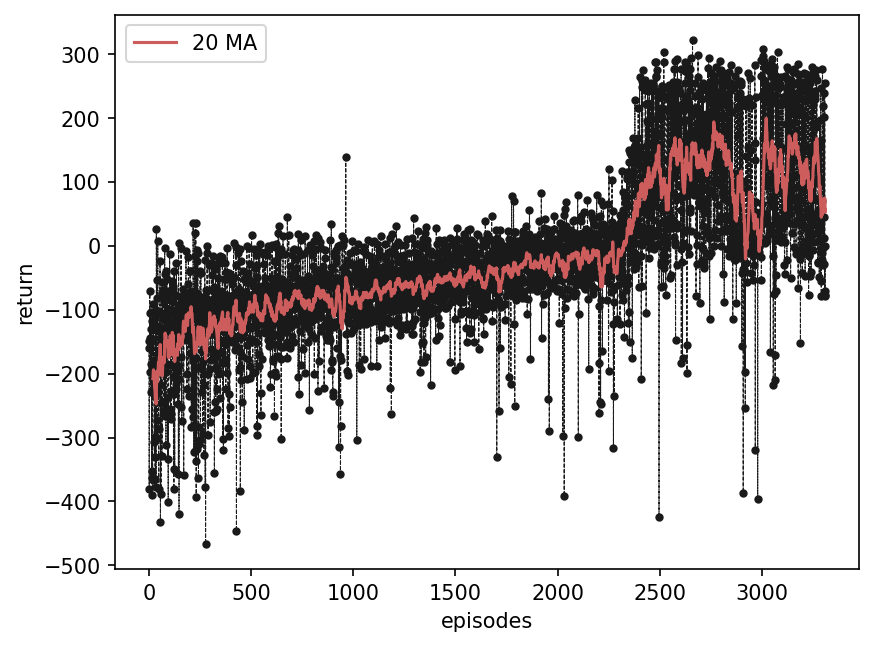

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

rolling_mean = (
    pd.Series(episode_rewards).rolling(window=20).mean()
)  # 20 episode moving average
plt.figure(dpi=150)
plt.plot(episode_rewards, c="0.1", lw=0.5, ls="--", marker="o", ms=3)
plt.plot(rolling_mean, c="indianred", label="20 MA")
plt.legend()
plt.xlabel("episodes")
plt.ylabel("return")

We can also evaluate the current learned model by using it on the environment.
If you are running on a local machine with the prerequisite packages, you can set `render=True` to have a screen display the rendered environment.

In [7]:
# model_policy = keras.models.load_model(f"dqn_600000.h5", compile=False)
# load the environment from openai gym
env = gym.make("LunarLander-v2", render_mode='human').env
state, info = env.reset()
done = False
episode_rewards = [0]
steps = 0
render = True # set to true when running on a local machine to visualize
for i in range(5000):
    if render:
        env.render() # for visualization, must be done on a local machine
    
    with torch.no_grad():
        action = agent.act(state, epsilon)

    # action_probs = model_policy(state[np.newaxis], training=False)
    action = action.numpy().squeeze()

    # Apply the sampled action in our environment
    state, reward, terminated, truncated, info = env.step(action)

    episode_rewards[-1] += reward
    steps += 1

    if steps == max_steps_per_episode:
        truncated = True
        steps = 0

    if terminated or truncated:
        state, info = env.reset()
        episode_rewards.append(0.0)

# Compute mean reward 
print(
    f"Mean reward: {np.mean(episode_rewards):.2f}\t Num episodes: {len(episode_rewards)}"
)

Mean reward: 21.53	 Num episodes: 15


In [8]:
action_probs

NameError: name 'action_probs' is not defined

## References
1. https://keras.io/examples/rl/deep_q_network_breakout/
2. https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
3. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#basic-usage-training-saving-loading
4. https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html